# Environment Setup

In [1]:
from config import *

import gensim
import logging
import numpy as np
import nltk
from time import time
import re
import os
import math as m
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.mpl_style = 'default'
from gensim import models

C:\Users\xt\Anaconda3\lib\site-packages\gensim\utils.py:855: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Slow version of gensim.models.doc2vec is being used
C:\Users\xt\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2881: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

df_all=pd.read_csv(PROCESSINGTEXT_DIR+"/df_train_and_test_processed.csv", encoding="ISO-8859-1")
df_all1=pd.read_csv(PROCESSINGTEXT_DIR+"/df_product_descriptions_processed.csv", encoding="ISO-8859-1")
df_all2=pd.read_csv(PROCESSINGTEXT_DIR+"/df_attribute_bullets_processed.csv", encoding="ISO-8859-1")

df_all = pd.merge(df_all, df_all1, how="left", on="product_uid")
df_all = pd.merge(df_all, df_all2, how="left", on="product_uid")

In [3]:
import seaborn as sns

df_all['majority_relevance'] = df_all['relevance'].map(lambda x: x in [1.0, 1.33, 1.67, 2.0, 2.33, 2.67, 3.0])
def majoritize(df):
    return df[df['majority_relevance'] == 1]

sns.set_palette("husl")

In [4]:
for var in df_all.keys():
    df_all[var]=df_all[var].fillna("")

In [5]:
remove_list=[str(x) for x in list(df_all.columns)]

for x in ['id']:
    remove_list.remove(x)

In [6]:
df_all[:3]

,id,product_title,product_uid,relevance,search_term,brand,product_title_simpleparsed,search_term_simpleparsed,search_term_parsed,is_query_misspelled,product_title_parsed,brand_parsed,material,material_parsed,search_term_parsed_woBrand,brands_in_search_term,search_term_parsed_woBM,materials_in_search_term,product_title_parsed_woBrand,brands_in_product_title,product_title_parsed_woBM,materials_in_product_title,search_term_tokens,product_title_tokens,search_term_stemmed,search_term_stemmed_woBM,search_term_stemmed_woBrand,product_title_stemmed,product_title_stemmed_woBM,product_title_stemmed_woBrand,product_description,product_description_parsed,product_description_parsed_woBrand,brands_in_product_description,product_description_parsed_woBM,materials_in_product_description,product_description_stemmed,attribute_bullets,attribute_bullets_parsed,attribute_bullets_parsed_woBrand,brands_in_attribute_bullets,attribute_bullets_parsed_woBM,materials_in_attribute_bullets,attribute_bullets_tokens,attribute_bullets_stemmed,majority_relevance
0,2,Simpson Strong-Tie 12-Gauge Angle,100001,3,angle bracket,Simpson Strong-Tie,simpson strong tie 12 gauge angle,angle bracket,angle bracket,1.000000,simpson strong tie 12 gauge angle,simpson,Galvanized Steel,galvanized steel,angle bracket,,angle bracket,,12 gauge angle,simpson strong tie,12 gauge angle,,"[(angle, NN), (bracket, NN)]","[(12, CD), (gauge, JJ), (angle, NN)]",angl bracket,angl bracket,angl bracket,simpson strong tie 12 gaug angl,12 gaug angl,12 gaug angl,"Not only do angles make joints stronger, they ...",not only do angles make joints stronger. they ...,not only do angles make joints stronger. they ...,simpson strong tie;versatile,not only do angles make joints stronger. they ...,steel;various;zinc,angl make joint stronger also provid consist s...,Versatile connector for various 90ÃÂ° connect...,versatile connector for various 90 connections...,connector for various 90 connections and home ...,versatile,connector for 90 connections and home repair p...,steel;various,"[(connector, NN), (for, IN), (90, CD), (connec...",versatil connector various 90 connect home rep...,True
1,3,Simpson Strong-Tie 12-Gauge Angle,100001,2.5,l bracket,Simpson Strong-Tie,simpson strong tie 12 gauge angle,l bracket,l bracket,1.000000,simpson strong tie 12 gauge angle,simpson,Galvanized Steel,galvanized steel,l bracket,,l bracket,,12 gauge angle,simpson strong tie,12 gauge angle,,"[(l, NN), (bracket, NN)]","[(12, CD), (gauge, NN), (angle, NN)]",l bracket,l bracket,l bracket,simpson strong tie 12 gaug angl,12 gaug angl,12 gaug angl,"Not only do angles make joints stronger, they ...",not only do angles make joints stronger. they ...,not only do angles make joints stronger. they ...,simpson strong tie;versatile,not only do angles make joints stronger. they ...,steel;various;zinc,angl make joint stronger also provid consist s...,Versatile connector for various 90ÃÂ° connect...,versatile connector for various 90 connections...,connector for various 90 connections and home ...,versatile,connector for 90 connections and home repair p...,steel;various,"[(connector, NN), (for, IN), (90, CD), (connec...",versatil connector various 90 connect home rep...,False
2,9,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,100002,3,deck over,BEHR Premium Textured DeckOver,behr premium textured deckover 1 gal sc 141 tu...,deck over,deckover,0.941176,behr premium textured deckover 1-gal sc141 tug...,behr,,,deckover,,deckover,,1-gal sc141 tugboat wood and concrete coating,behr premium textured deckover,1-gal sc141 tugboat and coating,concrete;wood,"[(deckover, NN)]","[(1-gal, JJ), (sc141, NN), (tugboat, NN), (and...",deckov,deckov,deckov,behr premium textur deckov 1-gal sc141 tugboat...,1-gal sc141 tugboat coat,1-gal sc141 tugboat wood concret coat,BEHR Premium Textured DECKOVER is an innovativ...,behr premium textured deckover is an innovativ...,is an innovative solid color coating. it will ...,behr premium textured deckover;behr,is 

# Bag-of-Word

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

cv = CountVectorizer(stop_words='english', max_features=1000)
cv.fit(df_all['search_term_stemmed'] + ' ' + df_all['product_title_stemmed']+ ' ' + \
                df_all['product_description_stemmed']+ ' ' + df_all['attribute_bullets_stemmed'])

search_term_cv = cv.transform(df_all['search_term_stemmed'])
product_title_cv = cv.transform(df_all['product_title_stemmed'])
product_desc_cv = cv.transform(df_all['product_description_stemmed'])
bullet_cv = cv.transform(df_all['attribute_bullets_stemmed'])

cv_st_pt_sim = [cosine_similarity(search_term_cv[i], product_title_cv[i])[0][0] for i in range(search_term_cv.shape[0])]
cv_st_pd_sim = [cosine_similarity(search_term_cv[i], product_desc_cv[i])[0][0] for i in range(search_term_cv.shape[0])]
cv_st_bl_sim = [cosine_similarity(search_term_cv[i], bullet_cv[i])[0][0] for i in range(search_term_cv.shape[0])]

df_all['cv_product_title_sim'] = cv_st_pt_sim
df_all['cv_product_desc_sim'] = cv_st_pd_sim
df_all['cv_bullet_sim'] = cv_st_bl_sim

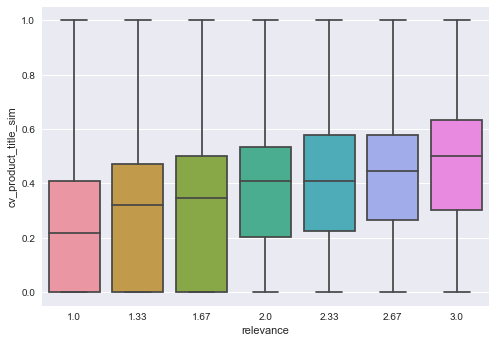

In [8]:
sns.boxplot(x='relevance', y='cv_product_title_sim', data=majoritize(df_all))

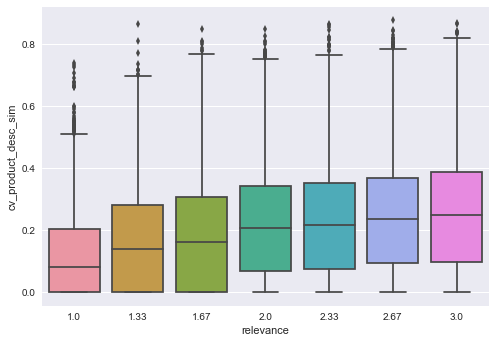

In [9]:
sns.boxplot(x='relevance', y='cv_product_desc_sim', data=majoritize(df_all))

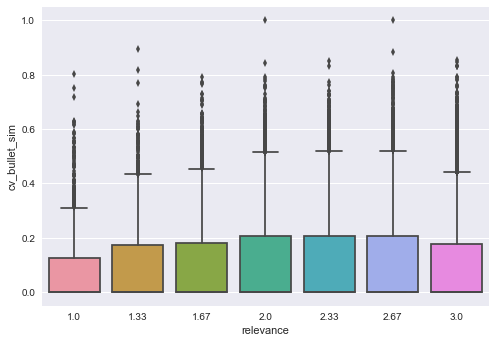

In [10]:
sns.boxplot(x='relevance', y='cv_bullet_sim', data=majoritize(df_all))

# Tf-Idf

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_model = TfidfVectorizer(stop_words='english',max_df=0.5) 
tfidf_model.fit(df_all['search_term_stemmed'] + ' ' + df_all['product_title_stemmed']+ ' ' + \
                df_all['product_description_stemmed']+ ' ' + df_all['attribute_bullets_stemmed'])

tfidf_model_search_term=tfidf_model.transform(df_all['search_term_stemmed'])
tfidf_model_product_title = tfidf_model.transform(df_all['product_title_stemmed'])
tfidf_model_product_desc = tfidf_model.transform(df_all['product_description_stemmed'])
tfidf_model_bullet = tfidf_model.transform(df_all['attribute_bullets_stemmed'])

tfidf_st_pt_sim = [cosine_similarity(tfidf_model_search_term[i], tfidf_model_product_title[i])[0][0] for i in range(tfidf_model_search_term.shape[0])]
tfidf_st_pd_sim = [cosine_similarity(tfidf_model_search_term[i], tfidf_model_product_desc[i])[0][0] for i in range(tfidf_model_search_term.shape[0])]
tfidf_st_bl_sim = [cosine_similarity(tfidf_model_search_term[i], tfidf_model_bullet[i])[0][0] for i in range(tfidf_model_search_term.shape[0])]

df_all['tfidf_product_title_sim'] = tfidf_st_pt_sim
df_all['tfidf_product_desc_sim'] = tfidf_st_pd_sim
df_all['tfidf_bullet_sim'] = tfidf_st_bl_sim

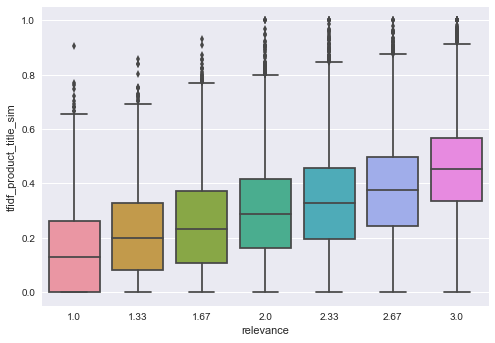

In [12]:
sns.boxplot(x='relevance', y='tfidf_product_title_sim', data=majoritize(df_all))

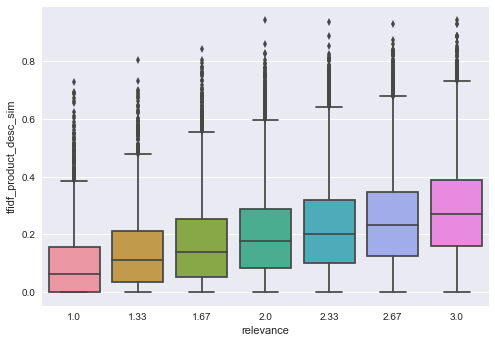

In [13]:
sns.boxplot(x='relevance', y='tfidf_product_desc_sim', data=majoritize(df_all))

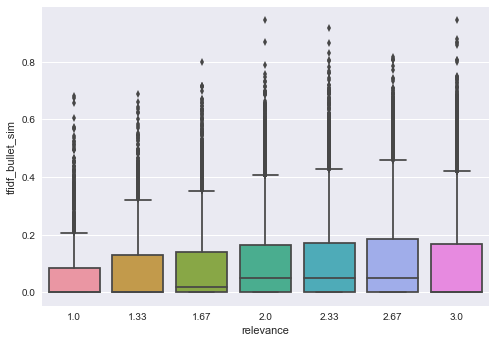

In [14]:
sns.boxplot(x='relevance', y='tfidf_bullet_sim', data=majoritize(df_all))

# Jaccard distance

In [15]:
def jaccard(A, B):
    C = A.intersection(B)
    return float(len(C)) / (len(A) + len(B) - len(C))

df_all['tokens_search_term'] = df_all['search_term_stemmed'].map(lambda x: x.split())
df_all['tokens_product_title'] = df_all['product_title_stemmed'].map(lambda x: x.split())
df_all['tokens_product_description'] = df_all['product_description_stemmed'].map(lambda x: x.split())
df_all['tokens_attribute_bullets'] = df_all['attribute_bullets_stemmed'].map(lambda x: x.split())

df_all['jaccard_product_title'] = df_all.apply(lambda x: jaccard(set(x['tokens_search_term']), set(x['tokens_product_title'])), axis=1)
df_all['jaccard_product_desc'] = df_all.apply(lambda x: jaccard(set(x['tokens_search_term']), set(x['tokens_product_description'])), axis=1)

ZeroDivisionError: ('float division by zero', 'occurred at index 17946')

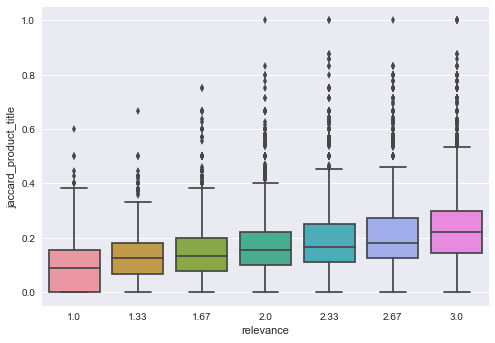

In [17]:
sns.boxplot(x='relevance', y='jaccard_product_title', data=majoritize(df_all))

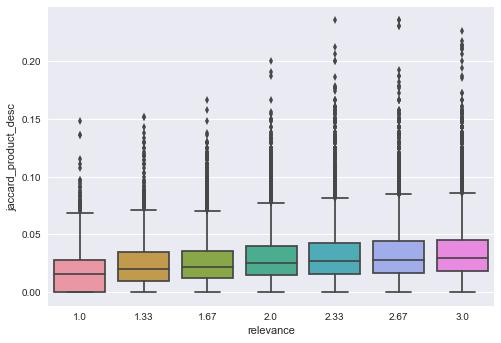

In [18]:
sns.boxplot(x='relevance', y='jaccard_product_desc', data=majoritize(df_all))

# Edit distance

In [26]:
from nltk.metrics import edit_distance

def calc_edit_distance(row, col):
    dists = [min([edit_distance(w, x) for x in row['tokens_'+col]]) for w in row['tokens_search_term']]
    return (min(dists), sum(dists)) if dists else (1,1.5)  

df_all['edit_product_title'] = df_all.apply(lambda x: calc_edit_distance(x, 'product_title'), axis=1)
#df_all['edit_product_desc'] = df_all.apply(lambda x: calc_edit_distance(x, 'product_description'), axis=1)

df_all['len_search_term'] = df_all['search_term_stemmed'].map(lambda x:len(x.split())).astype(np.int64)

#df_all['edit_product_title_min'] = df_all['edit_product_title'].map(lambda x: x[0])
df_all['edit_product_title_avg'] = df_all['edit_product_title'].map(lambda x: x[1]) / df_all['len_search_term']
#df_all['edit_product_desc_min'] = df_all['edit_product_desc'].map(lambda x: x[0])
#df_all['edit_product_desc_avg'] = df_all['edit_product_desc'].map(lambda x: x[1]) / df_all['len_search_term']

KeyboardInterrupt: 

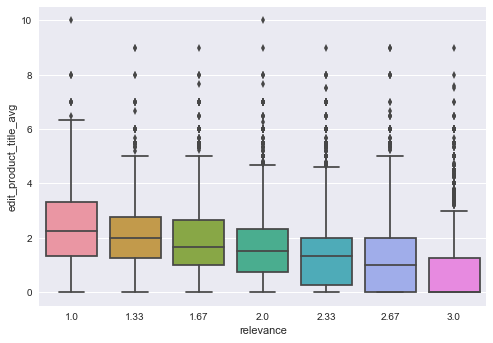

In [29]:
sns.boxplot(x='relevance', y='edit_product_title_avg', data=majoritize(df_all))

# Create csv

In [ ]:
df_all = df_all.drop(['edit_product_title','edit_product_title_min','len_search_term','tokens_search_term','tokens_product_title',\
                      'tokens_product_description','tokens_attribute_bullets'],axis=1)
#df_all = df_all.drop(['edit_product_title','edit_product_desc','len_search_term','tokens_search_term','tokens_product_title',\
#                      'tokens_product_description','tokens_attribute_bullets'],axis=1)
df_all = df_all.drop(remove_list,axis=1)

In [38]:
df_all[:2]

,id,product_title,product_uid,relevance,search_term,brand,product_title_simpleparsed,search_term_simpleparsed,search_term_parsed,is_query_misspelled,product_title_parsed,brand_parsed,material,material_parsed,search_term_parsed_woBrand,brands_in_search_term,search_term_parsed_woBM,materials_in_search_term,product_title_parsed_woBrand,brands_in_product_title,product_title_parsed_woBM,materials_in_product_title,search_term_tokens,product_title_tokens,search_term_stemmed,search_term_stemmed_woBM,search_term_stemmed_woBrand,product_title_stemmed,product_title_stemmed_woBM,product_title_stemmed_woBrand,product_description,product_description_parsed,product_description_parsed_woBrand,brands_in_product_description,product_description_parsed_woBM,materials_in_product_description,product_description_stemmed,attribute_bullets,attribute_bullets_parsed,attribute_bullets_parsed_woBrand,brands_in_attribute_bullets,attribute_bullets_parsed_woBM,materials_in_attribute_bullets,attribute_bullets_tokens,attribute_bullets_stemmed,majority_relevance,cv_product_title_sim,cv_product_desc_sim,cv_bullet_sim,tfidf_product_title_sim,tfidf_product_desc_sim,tfidf_bullet_sim,tokens_search_term,tokens_product_title,tokens_product_description,tokens_attribute_bullets,jaccard_product_title,jaccard_product_desc,edit_product_title,len_search_term,edit_product_title_min,edit_product_title_avg
0,2,Simpson Strong-Tie 12-Gauge Angle,100001,3,angle bracket,Simpson Strong-Tie,simpson strong tie 12 gauge angle,angle bracket,angle bracket,1.0,simpson strong tie 12 gauge angle,simpson,Galvanized Steel,galvanized steel,angle bracket,,angle bracket,,12 gauge angle,simpson strong tie,12 gauge angle,,"[(angle, NN), (bracket, NN)]","[(12, CD), (gauge, JJ), (angle, NN)]",angl bracket,angl bracket,angl bracket,simpson strong tie 12 gaug angl,12 gaug angl,12 gaug angl,"Not only do angles make joints stronger, they ...",not only do angles make joints stronger. they ...,not only do angles make joints stronger. they ...,simpson strong tie;versatile,not only do angles make joints stronger. they ...,steel;various;zinc,angl make joint stronger also provid consist s...,Versatile connector for various 90ÃÂ° connect...,versatile connector for various 90 connections...,connector for various 90 connections and home ...,versatile,connector for 90 connections and home repair p...,steel;various,"[(connector, NN), (for, IN), (90, CD), (connec...",versatil connector various 90 connect home rep...,True,0.316228,0.19696,0.116248,0.271231,0.192254,0.111598,"[angl, bracket]","[simpson, strong, tie, 12, gaug, angl]","[angl, make, joint, stronger, also, provid, co...","[versatil, connector, various, 90, connect, ho...",0.142857,0.014085,"(0, 6)",2,0,3.0
1,3,Simpson Strong-Tie 12-Gauge Angle,100001,2.5,l bracket,Simpson Strong-Tie,simpson strong tie 12 gauge angle,l bracket,l bracket,1.0,simpson strong tie 12 gauge angle,simpson,Galvanized Steel,galvanized steel,l bracket,,l bracket,,12 gauge angle,simpson strong tie,12 gauge angle,,"[(l, NN), (bracket, NN)]","[(12, CD), (gauge, NN), (angle, NN)]",l bracket,l bracket,l bracket,simpson strong tie 12 gaug angl,12 gaug angl,12 gaug angl,"Not only do angles make joints stronger, they ...",not only do angles make joints stronger. they ...,not only do angles make joints stronger. they ...,simpson strong tie;versatile,not only do angles make joints stronger. they ...,steel;various;zinc,angl make joint stronger also provid consist s...,Versatile connector for various 90ÃÂ° connect...,versatile connector for various 90 connections...,connector for various 90 connections and home ...,versatile,connector for 90 connections and home repair p...,steel;various,"[(connector, NN), (for, IN), (90, CD), (connec...",versatil connector various 90 connect home rep...,False,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,"[l, bracket]","[simpson, strong, tie, 12, gaug, angl]","[angl, make, joint, stronger, also, provid, co...","[versatil, connector, various, 90, con

In [ ]:
df_all.to_csv(FEATURES_DIR+"/distance_related_features.csv", index=False) 

# Latent Semantic Indexing

In [51]:
df_LSI = df_all[['id']]

In [52]:
from sklearn.decomposition import TruncatedSVD

tsvd = TruncatedSVD(n_components=10, random_state=2016)

st_bow_tsvd = tsvd.fit_transform(search_term_cv)
for i in range(st_bow_tsvd.shape[1]):
    df_LSI['st_bow_tsvd'+str(i)] = st_bow_tsvd[:,i]

pt_bow_tsvd = tsvd.fit_transform(product_title_cv )
for i in range(pt_bow_tsvd.shape[1]):
    df_LSI['pt_bow_tsvd'+str(i)] = pt_bow_tsvd[:,i]

pd_bow_tsvd = tsvd.fit_transform(product_desc_cv )
for i in range(pd_bow_tsvd.shape[1]):
    df_LSI['pd_bow_tsvd'+str(i)] = pd_bow_tsvd[:,i]

bl_bow_tsvd = tsvd.fit_transform(bullet_cv)
for i in range(bl_bow_tsvd.shape[1]):
    df_LSI['bl_bow_tsvd'+str(i)] = bl_bow_tsvd[:,i]

st_tfidf_tsvd = tsvd.fit_transform(tfidf_model_search_term)
for i in range(st_tfidf_tsvd.shape[1]):
    df_LSI['st_tfidf_tsvd_'+str(i)] = st_tfidf_tsvd[:,i]

pt_tfidf_tsvd = tsvd.fit_transform(tfidf_model_product_title)
for i in range(pt_tfidf_tsvd.shape[1]):
    df_LSI['pt_tfidf_tsvd_'+str(i)] = pt_tfidf_tsvd[:,i]

pd_tfidf_tsvd = tsvd.fit_transform(tfidf_model_product_desc)
for i in range(pd_tfidf_tsvd.shape[1]):
    df_LSI['pd_tfidf_tsvd_'+str(i)] = pd_tfidf_tsvd[:,i]

bl_tfidf_tsvd = tsvd.fit_transform(tfidf_model_bullet)
for i in range(bl_tfidf_tsvd.shape[1]):
    df_LSI['bl_tfidf_tsvd_'+str(i)] = bl_tfidf_tsvd[:,i]

C:\Users\xt\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\xt\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\xt\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-ve

In [53]:
df_LSI

,id,st_bow_tsvd0,st_bow_tsvd1,st_bow_tsvd2,st_bow_tsvd3,st_bow_tsvd4,st_bow_tsvd5,st_bow_tsvd6,st_bow_tsvd7,st_bow_tsvd8,st_bow_tsvd9,pt_bow_tsvd0,pt_bow_tsvd1,pt_bow_tsvd2,pt_bow_tsvd3,pt_bow_tsvd4,pt_bow_tsvd5,pt_bow_tsvd6,pt_bow_tsvd7,pt_bow_tsvd8,pt_bow_tsvd9,pd_bow_tsvd0,pd_bow_tsvd1,pd_bow_tsvd2,pd_bow_tsvd3,pd_bow_tsvd4,pd_bow_tsvd5,pd_bow_tsvd6,pd_bow_tsvd7,pd_bow_tsvd8,pd_bow_tsvd9,bl_bow_tsvd0,bl_bow_tsvd1,bl_bow_tsvd2,bl_bow_tsvd3,bl_bow_tsvd4,bl_bow_tsvd5,bl_bow_tsvd6,bl_bow_tsvd7,bl_bow_tsvd8,bl_bow_tsvd9,st_tfidf_tsvd_0,st_tfidf_tsvd_1,st_tfidf_tsvd_2,st_tfidf_tsvd_3,st_tfidf_tsvd_4,st_tfidf_tsvd_5,st_tfidf_tsvd_6,st_tfidf_tsvd_7,st_tfidf_tsvd_8,st_tfidf_tsvd_9,pt_tfidf_tsvd_0,pt_tfidf_tsvd_1,pt_tfidf_tsvd_2,pt_tfidf_tsvd_3,pt_tfidf_tsvd_4,pt_tfidf_tsvd_5,pt_tfidf_tsvd_6,pt_tfidf_tsvd_7,pt_tfidf_tsvd_8,pt_tfidf_tsvd_9,pd_tfidf_tsvd_0,pd_tfidf_tsvd_1,pd_tfidf_tsvd_2,pd_tfidf_tsvd_3,pd_tfidf_tsvd_4,pd_tfidf_tsvd_5,pd_tfidf_tsvd_6,pd_tfidf_tsvd_7,pd_tfidf_tsvd_8,pd_tfidf_tsvd_9,bl_tfidf_tsvd_0,bl_tfidf_tsvd_1,bl_tfidf_tsvd_2,bl_tfidf_tsvd_3,bl_tfidf_tsvd_4,bl_tfidf_tsvd_5,bl_tfidf_tsvd_6,bl_tfidf_tsvd_7,bl_tfidf_tsvd_8,bl_tfidf_tsvd_9
0,2,5.191693e-03,7.733106e-04,8.008886e-03,-9.417227e-04,6.788371e-03,6.536005e-03,6.752236e-03,1.024724e-02,-5.226411e-03,8.076031e-03,0.163678,-0.043543,-0.223910,0.427479,-0.380212,0.022372,-0.001904,0.333956,-0.018845,0.352031,2.892841,-0.545631,0.074810,-0.146206,0.506657,0.388687,-0.067663,-0.176000,-0.601222,-0.714585,0.980155,-0.092921,-0.336164,-0.470859,-0.184183,-0.310238,-0.185504,-0.333228,-0.115051,0.112784,6.101281e-03,4.145653e-03,2.970258e-03,-3.422055e-03,5.990477e-03,7.316428e-03,2.442720e-03,7.794200e-04,-3.323968e-04,1.513175e-02,0.068977,0.022891,0.031235,0.044933,-0.054612,-0.029514,0.097865,-0.059479,-0.059466,0.038606,0.180881,-0.019319,0.005699,0.051542,-0.083429,-0.072929,-0.129160,0.037023,-0.124322,-0.021425,0.133652,-0.034799,-0.021174,-0.039607,0.054978,-0.122307,-0.013745,-0.087655,-0.047306,-0.005254
1,3,2.260202e-03,1.558596e-03,5.595447e-03,2.826872e-04,1.355302e-03,4.263715e-03,5.759169e-03,5.415061e-03,-3.193212e-03,7.819912e-03,0.163678,-0.043543,-0.223910,0.427479,-0.380212,0.022372,-0.001904,0.333956,-0.018845,0.352031,2.892841,-0.545631,0.074810,-0.146206,0.506657,0.388687,-0.067663,-0.176000,-0.601222,-0.714585,0.980155,-0.092921,-0.336164,-0.470859,-0.184183,-0.310238,-0.185504,-0.333228,-0.115051,0.112784,5.305690e-03,4.982050e-03,2.257439e-03,-4.706652e-03,4.316261e-03,5.589696e-03,3.027859e-03,6.109895e-04,2.663374e-03,2.138460e-02,0.068977,0.022891,0.031235,0.044933,-0.054612,-0.029514,0.097865,-0.059479,-0.059466,0.038606,0.180881,-0.019319,0.005699,0.051542,-0.083429,-0.072929,-0.129160,0.037023,-0.124322,-0.021425,0.133652,-0.034799,-0.021174,-0.039607,0.054978,-0.122307,-0.013745,-0.087655,-0.047306,-0.005254
2,9,1.428654e-15,-2.795180e-15,-3.595256e-14,-1.146452e-13,-1.020732e-14,-1.021872e-13,-2.996095e-14,-1.073014e-14,3.397991e-15,4.598863e-14,0.091309,-0.058458,-0.160756,-0.000333,-0.013808,0.138391,-0.007373,0.300338,0.190633,0.726900,4.101090,-1.159744,-2.980719,-0.483510,2.309307,6.108467,1.128420,2.257624,1.707984,0.462063,2.457907,-0.663820,-2.003518,-2.608981,-1.517659,4.098339,0.016370,1.763626,2.356556,0.243282,8.171803e-05,1.839158e-05,1.068363e-04,-2.799156e-05,-9.525349e-05,1.024888e-04,5.536528e-05,1.432993e-04,-5.582783e-04,3.841688e-04,0.027713,-0.003170,0.013233,-0.001059,-0.036196,-0.034372,0.001194,0.014505,-0.036623,0.004301,0.258896,0.094069,-0.151956,0.382640,0.175310,-0.021215,0.007937,-0.027469,0.016573,-0.019968,0.259339,-0.029620,-0.327604,0.417288,-0.052349,0.009397,-0.108424,-0.050627,0.009317,0.032675
3,16,2.797381e-03,-3.219294e-04,4.942005e-03,-5.914236e-03,2.058828e-02,6.633585e-03,7.243758e-03,2.804362e-03,-5.472440e-03,-6.919980e-04,0.173201,-0.208004,-0.264095,-0.282087,-0.198090,0.514054,1.378962,-0.451897,-1.081734,-0.147549,2.307932,-0.003718,-0.022446,-1.131040,-0.630840,0.442707,-1.670320,-0.1

In [55]:
df_LSI.to_csv(FEATURES_DIR+"/latent_semantic_indexing.csv", index=False) 